In [1]:
import sys
root_dir = "/Users/krishna/Desktop/Study/NLP Assignments/Course_Project/"
sys.path.append('/Users/krishna/Desktop/Study/NLP Assignments/Course_Project/PDF')

In [3]:
import time
from layout_parser_functions import init_models, extract_pages_and_images, process_page, visualize_layout
from pdfplumber_functions import extract_words_from_pdf, generate_and_display_images_pdfplumber
from merge_boxes import merge_boxes
from treeify import generate_tree
import json, os
from PyPDF2 import PdfMerger

In [4]:
def merge_pdfs(dir_path, output_filename, prefix):
    merger = PdfMerger()

    for item in sorted(os.listdir(dir_path)):
        if item.endswith('.pdf') and item.startswith(prefix):
            merger.append(os.path.join(dir_path, item))

    merger.write(dir_path + "//" + output_filename)
    merger.close()
    
def delete_pdfs(dir_path, prefix):
    for item in os.listdir(dir_path):
        if item.endswith('.pdf') and item.startswith(prefix):
            os.remove(os.path.join(dir_path, item))

In [5]:
def process_pdf(pdf_file_path, use_layoutparser=True, use_pdfplumber=True, generate_images=False):
    lp_all_word_data, pdfplumber_all_words, pymupdf_all_words = [], [], []
    lp_all_layout_data = []

    # Create output directories if they do not exist
    os.makedirs(root_dir + 'PDF/output/PDF', exist_ok=True)
    os.makedirs(root_dir + 'PDF/output/visuals', exist_ok=True)

    if use_layoutparser:
        start = time.time()
        lp_model, ocr_agent = init_models()
        lp_pdf_layout, lp_images = extract_pages_and_images(pdf_file_path)

        for i, image in enumerate(lp_images):
            print(f"Processing page {i+1}/{len(lp_images)} with LayoutParser...")
            # if i+1 <= 1:
            word_data, layout, layout_data = process_page(lp_model, ocr_agent, image, i)
            lp_all_word_data.extend(word_data)
            lp_all_layout_data.extend(layout_data)
            
            if generate_images:
                layout_svg = visualize_layout(image, layout, word_data, layout_data, i)
        
        if generate_images:
            merge_pdfs(root_dir + "PDF/output/visuals", "lp_output.pdf", "layout_visualization_page_")
            delete_pdfs(root_dir + "PDF/output/visuals", "layout_visualization_page_")

        with open(root_dir + 'PDF/output/PDF/lp_output_words.json', 'w') as f:
            json.dump(lp_all_word_data, f, indent=4)
        
        with open(root_dir + 'PDF/output/PDF/lp_output_layout.json', 'w') as f:
            json.dump(lp_all_layout_data, f, indent=4)
        end = time.time()
        print("LayoutParser processing took", end - start, "seconds")

    if use_pdfplumber:
        start = time.time()
        print("Processing document with pdfplumber...")
        pdfplumber_all_words = extract_words_from_pdf(pdf_file_path)
        if generate_images:
            generate_and_display_images_pdfplumber(pdf_file_path, pdfplumber_all_words)
            merge_pdfs(root_dir + "PDF/output/visuals", "pdfplumber_output.pdf", "pdfplumber_output_page_")
            delete_pdfs(root_dir + "PDF/output/visuals", "pdfplumber_output_page_")

        with open(root_dir + 'PDF/output/PDF/pdfplumber_output.json', 'w') as f:
            json.dump(pdfplumber_all_words, f, indent=4)
        end = time.time()
        print("pdfplumber processing took", end - start, "seconds")

    all_word_data_pdfplumber = pdfplumber_all_words
    merged_boxes_pdfplumber, new_layout_data_pdfplumber = merge_boxes(all_word_data_pdfplumber, lp_all_layout_data, 'pdfplumber')

    all_word_data_pymupdf = pymupdf_all_words
    merged_boxes_pymupdf, new_layout_data_pymupdf = merge_boxes(all_word_data_pymupdf, lp_all_layout_data, 'pymupdf')

    with open(root_dir + 'PDF/output/PDF/merged_boxes_lp_pdfplumber.json', 'w') as f:
        json.dump(merged_boxes_pdfplumber, f, indent=4)
        
    with open(root_dir + 'PDF/output/PDF/new_layout_data_lp_pdfplumber.json', 'w') as f:
        json.dump(new_layout_data_pdfplumber, f, indent=4)

    # pdf_tree_pdfplumber = generate_tree(new_layout_data_pdfplumber)
    # with open(root_dir + 'PDF/output/PDF/pdf_tree_data_pdfplumber.json', 'w') as f:
    #     json.dump(pdf_tree_pdfplumber, f, indent=4)

    return new_layout_data_pdfplumber

In [6]:
new_layout_data = process_pdf(root_dir + "PDF/documents/attention.pdf", use_layoutparser=True, use_pdfplumber=True, generate_images=True)

Processing page 1/11 with LayoutParser...


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing page 2/11 with LayoutParser...
Processing page 3/11 with LayoutParser...
Processing page 4/11 with LayoutParser...
Processing page 5/11 with LayoutParser...
Processing page 6/11 with LayoutParser...
Processing page 7/11 with LayoutParser...
Processing page 8/11 with LayoutParser...
Processing page 9/11 with LayoutParser...
Processing page 10/11 with LayoutParser...
Processing page 11/11 with LayoutParser...
LayoutParser processing took 49.09262013435364 seconds
Processing document with pdfplumber...
Processing page 1/11...
Processing page 2/11...
Processing page 3/11...
Processing page 4/11...
Processing page 5/11...
Processing page 6/11...
Processing page 7/11...
Processing page 8/11...
Processing page 9/11...
Processing page 10/11...
Processing page 11/11...
Generating image for page 1/11...
Generating image for page 2/11...
Generating image for page 3/11...
Generating image for page 4/11...
Generating image for page 5/11...
Generating image for page 6/11...
Generating ima

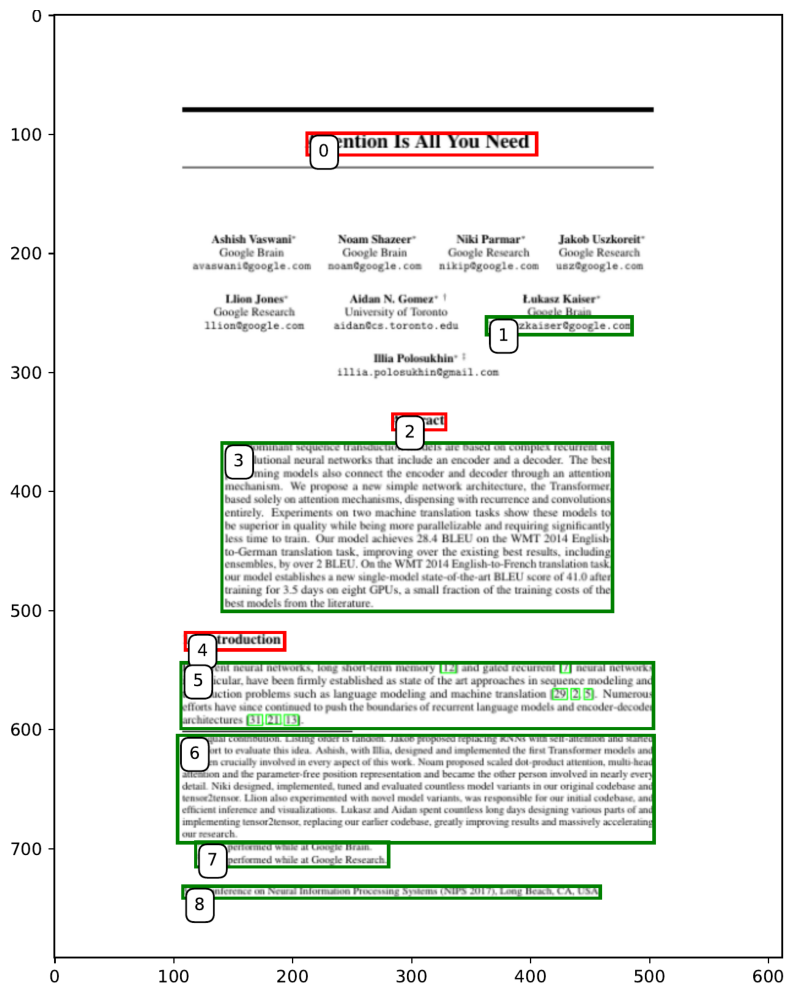

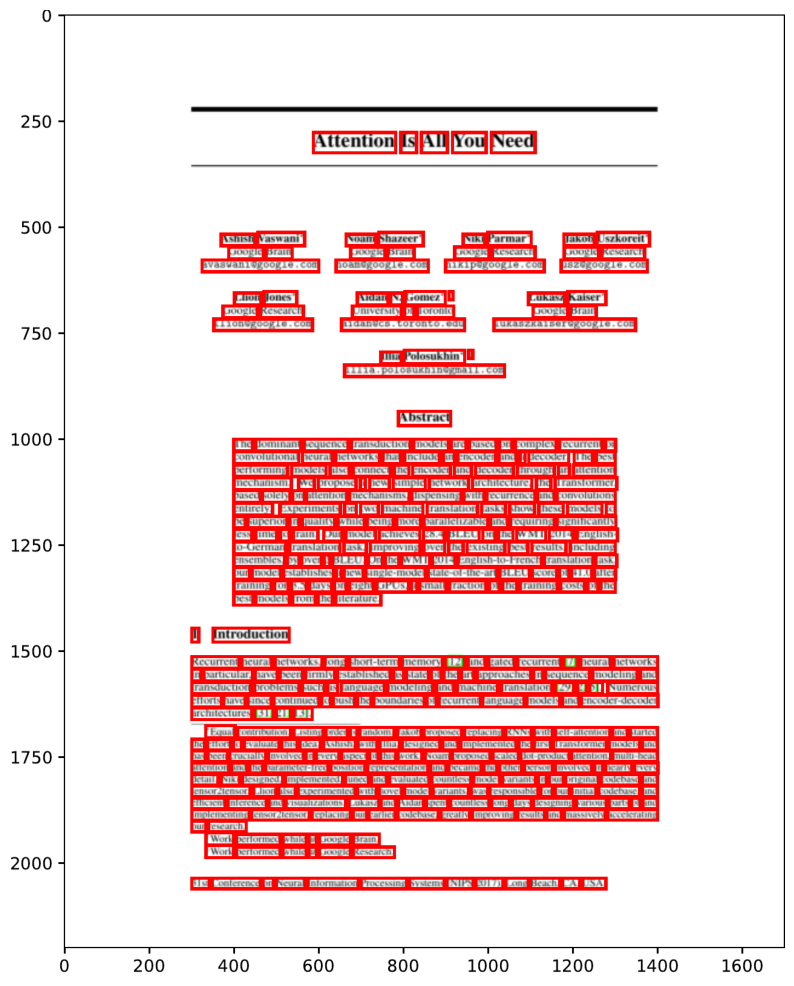

In [7]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

layout_images = convert_from_path(root_dir + 'PDF/output/visuals/lp_output.pdf')

img = layout_images[0]
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis('off')
plt.show()

words_images = convert_from_path(root_dir + 'PDF/output/visuals/pdfplumber_output.pdf')

img = words_images[0]
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis('off')
plt.show()


In [8]:
import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)
        
RenderJSON(pdf_tree)

NameError: name 'pdf_tree' is not defined

In [ ]:
import json
file_path = root_dir + 'PDF/output/pdf_tree.json'

with open(file_path, 'w') as file:
    json.dump(pdf_tree, file, indent=4)

NameError: name 'pdf_tree' is not defined

In [9]:
import json
file_path = root_dir + 'PDF/output/chunks.json'

with open(file_path, 'w') as file:
    json.dump(new_layout_data, file, indent=4)

In [10]:
import numpy as np
import json
import sentence_transformers

model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')

# Load JSON data from file
with open(root_dir + 'PDF/output/chunks.json', 'r') as file:
    chunks = json.load(file)

# Extract content and ids
contents = [item["content"] for item in chunks]
ids = [item["id"] for item in chunks]

# Generate embeddings for the contents
embeddings = model.encode(contents)

# Save the embeddings and ids to .npy files
np.save(root_dir + 'PDF/output/embeddings.npy', embeddings)
np.save(root_dir + 'PDF/output/ids.npy', ids)


In [11]:
user_query = "Application of attention"
query_embed = model.encode([user_query])

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings and ids from .npy files
embeddings = np.load(root_dir + 'PDF/output/embeddings.npy')
ids = np.load(root_dir + 'PDF/output/ids.npy', allow_pickle=True)

print(ids[0])

# Calculate cosine similarity between query and all embeddings
similarities = cosine_similarity(query_embed, embeddings)

# Find the top 4 indices
top_indices = np.argsort(similarities[0])[::-1][:4]
top_scores = np.sort(similarities[0])[::-1][:4]

# Retrieve and print the corresponding strings and scores
for index, score in zip(top_indices, top_scores):
    content_id = ids[index]

    # Assuming chunks is the list of dictionaries loaded from 'chunks.json'
    corresponding_string = "No matching content found"
    for item in chunks:
        if item["id"] == content_id:
            corresponding_string = item["content"]
            break

    print(f"Score: {score:.4f}, Text: {corresponding_string}")


33bb5be2-697c-4e5e-88fd-d4fa180f07c7
Score: 0.7426, Text: 3.2.3 Applications of Attention in our Model
Score: 0.7082, Text: Why Self-Attention
Score: 0.6927, Text: Attention Is All You Need
Score: 0.6302, Text: Assidebenefit, self-attentioncouldyieldmoreinterpretablemodels. Weinspectattentiondistributions from our models and present and discuss examples in the appendix. Not only do individual attention heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic and semantic structure of the sentences.
